# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
# %matplotlib qt
import logging
# logging.basicConfig(level=logging.WARNING, format=' - %(levelname)s - %(message)s')

In [2]:
import poppy
from xupy import typings as xt
import xupy as xp
import astropy.units as u
from astropy import convolution as c
from astropy.io import fits
from astropy.table import QTable
from matplotlib import pyplot as plt
from simulator import BinarySystem
from instruments import CCD
import utils as ut

Gpb = QTable.read("data/gaiaDR3passband.fits")
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int, axis_ratio: tuple[int,int] = (1,1)) -> fits.HDUList:
    """
    Rebin PSF by a given factor, following Gaia's pixel scale (1:3 ratio).
    """
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor*axis_ratio[0], rebin_factor*axis_ratio[1])
    return poppy.utils.rebin_array(psf, px_ratio)

/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')



[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 5080 Laptop GPU`
       Memory = 16230.98 MB | Compute Capability = 12.0
       Using CuPy 13.5.1 for acceleration.


```py
poppy.conf.n_processes = 20
poppy.conf.use_cupy = False
poppy.conf.use_multiprocessing = False
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", height=1.45*u.m, width=0.5*u.m)
# M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_pixels=(2124,1062), oversample=1)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

poppy.utils.display_psf(psf[0], title="Gaia PSF", vmax=psf[0][0].data.max())
psf[0].writeto("data/simulations/PSFs/20250923_3_gaia_psf_T.fits", overwrite=True)

## Got The PSF: Now on to the convolution

In [3]:
@ut.timer
def cpu_fft(**kwargs):
    return c.convolve_fft(**kwargs)

@ut.timer
def gpu_fft(**kwargs):
    from processing import convolve_fft
    return convolve_fft(**kwargs)

#### Creating the **Binary Star System (BSS)** and the **CCD**

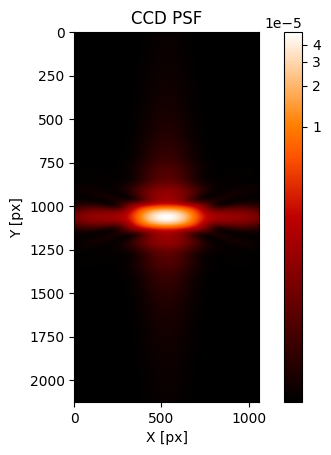

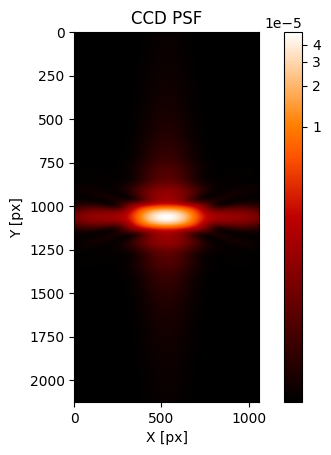

In [4]:
ccd = CCD(psf="data/simulations/PSFs/1062x2124_gpsf_T.fits", pixel_scale_x = 177*u.mas, pixel_scale_y = 59*u.mas)
bs = BinarySystem(ccd=ccd, M1=8, M2=8, distance=200, angle=45.)

ccd.display_psf()

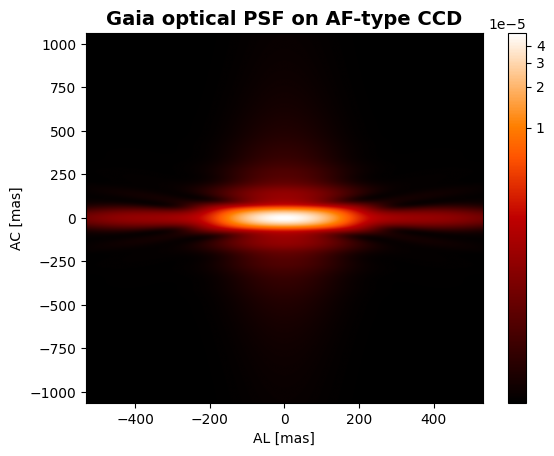

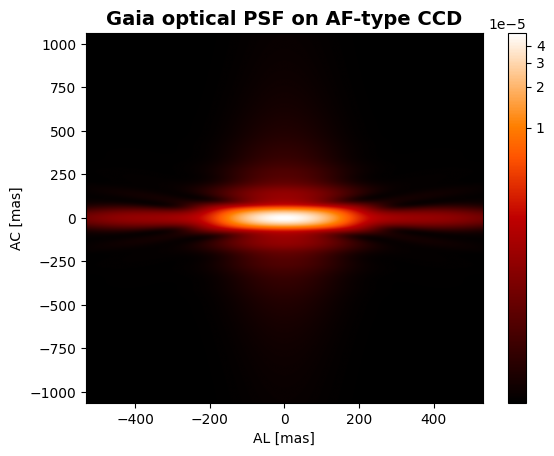

In [6]:
ut.display_psf(ccd.psf, mode='2d', aspect='auto', save='psf', title='Gaia optical PSF on AF-type CCD')

In [ ]:
rbfactor = int(ccd.pxscale_y.value)
ratio = int(1/ccd.pxscale_factor)
rbratio = (rbfactor * ratio, rbfactor)
print(rbratio)

In [ ]:
map = bs.show_system(out=True, origin='lower')

In [2]:
from main import main
from instruments import CCD
from astropy import units as u

ccd = CCD(psf="data/simulations/PSFs/1062x2124_gpsf_T.fits", pixel_scale_x = 177*u.mas, pixel_scale_y = 59*u.mas)

main(7,7, 200, 360, ccd=ccd)

[20251008_155310] Observing...: 100%|██████████| 1232/1232 [06:26<00:00,  3.18images/s]


20251008_155310
